In [1]:
import os
import sys
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import cv2
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
import torchvision

WORK_DIR = Path(Path.cwd()).parent
sys.path.append(str(WORK_DIR))
from src.datasets import get_dataset, get_dataloader, TSN_Labels
from src.utils import parse_data_cfg, IMG, TSN, FPHA, DATA_DIR, LMDB
from src.models import get_model

In [2]:
exp_fold = ''
cfgname = 'hpo_tsn_fpha_base'
cfg = parse_data_cfg(WORK_DIR/'data_cfg'/exp_fold/(cfgname + '.cfg'))
epoch = 0
exp_dir = cfg["exp_dir"]
data_split = 'train'
data_list = cfg[data_split + '_set']
class_dict = FPHA.get_class_name_dict()

# Train dataloader

In [ ]:
model = get_model(cfg, True, epoch, None, None)

In [4]:
input, target = next(iter(model.train_loader))
input = input.permute(0, 2, 3, 1)
print(input.shape)

torch.Size([16, 416, 416, 9])


In [5]:
idx = 0
cur_input = input[idx]
cur_target = target[idx].item()
cur_target = class_dict[cur_target]

img1 = cur_input[:, :, :3]
img2 = cur_input[:, :, 3:6]
img3 = cur_input[:, :, 6:]

img1 = cv2.normalize(np.asarray(img1), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
img2 = cv2.normalize(np.asarray(img2), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
img3 = cv2.normalize(np.asarray(img3), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)

give_coin


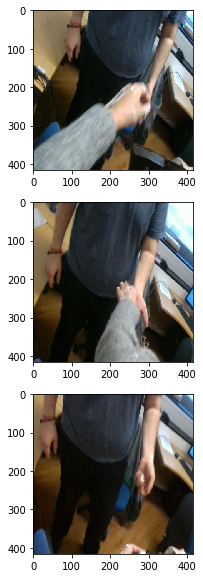

In [6]:
print(cur_target)
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

# Test dataloader

In [7]:
cfg['num_segments'] = 1
cfg['test_segments'] = 1

model = get_model(cfg, False, epoch, None, None)

In [8]:
data_set        = data_split + '_set'
dataset_kwargs  = {'split_set': cfg[data_set]}
cfg['aug']      = None
pred_tfm = torchvision.transforms.Compose([
    TSN.Stack(roll=False),
    TSN.ToTorchFormatTensor(div=True),
    TSN.GroupNormalize(model.net.input_mean, model.net.input_std)])
pred_dataset = TSN_Labels(cfg, cfg[data_set], pred_tfm,
                             random_shift=True, test_mode=True)
pred_kwargs =  {'batch_size'  :   1,
                'shuffle'     :   True,
                'num_workers' :   int(cfg['num_workers']),
                'pin_memory'  :   True}
data_loader = DataLoader(pred_dataset,
                         sampler=None,
                         **pred_kwargs)


In [9]:
input, target = next(iter(data_loader))
input = input.permute(0, 2, 3, 1)
print(input.shape)

torch.Size([1, 416, 416, 3])


In [15]:
idx = 0
cur_input = input[idx]
cur_input = cv2.normalize(np.asarray(cur_input), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8UC3)
cur_target = target[idx].item()
cur_target = class_dict[cur_target]
print(cur_target)

open_juice_bottle


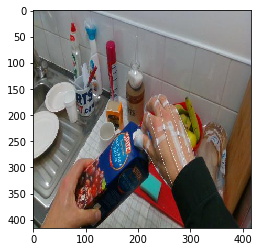

In [17]:
fig, ax = plt.subplots()
ax.imshow(cur_input)


# Evaluation

In [4]:
split_set = cfg['hpo_' + data_split + '_set']
keys = LMDB.get_keys(os.path.join(DATA_DIR, split_set + "_keys_cache.p"))

xyz_gt = LMDB.read_all_lmdb_dataroot(keys, os.path.join(DATA_DIR, split_set + '_xyz_gt.lmdb'), 'float32', (21, 3))
uvd_gt = FPHA.xyz2uvd_color(xyz_gt)

100%|██████████| 45325/45325 [00:00<00:00, 433487.54it/s]


In [5]:
pred_file = os.path.join(DATA_DIR, exp_dir, 'predict_{}_{}_uvd.txt'.format(epoch, data_split))
pred_uvd = np.reshape(np.loadtxt(pred_file), (-1, 21, 3))
pred_uvd = IMG.scale_points_WH(pred_uvd, (1, 1), (1920, 1080))
pred_uvd[..., 2] *= 1000
pred_xyz = FPHA.uvd2xyz_color(pred_uvd)


Subject_1/sprinkle/2/color/color_0067.jpeg


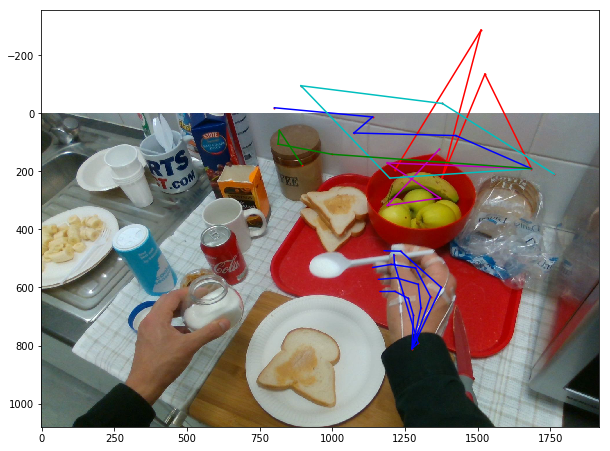

In [8]:
idx = 1000
print(keys[idx])

img = np.asarray(Image.open(os.path.join(DATA_DIR, 'First_Person_Action_Benchmark', 'Video_files', keys[idx])))
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img)

FPHA.visualize_joints_2d(ax, pred_uvd[idx][FPHA.REORDER_IDX], joint_idxs=False)
FPHA.visualize_joints_2d(ax, uvd_gt[idx][FPHA.REORDER_IDX], joint_idxs=False, c='b')